In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(rq):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(rq, conn)

In [3]:
def run_command(rc):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(rc)

In [4]:
def show_tables():
    rq = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view")''';
    return run_query(rq)
        

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


<font color=blue>FIRST QUESTION & SOLUTION STRATEGY
<br><br>
*QUESTION*</font>

We need to select three albums as our initial offerings from our record store.  
We have four artists to select from, representing the genres Hip_Hop, Punk, Pop and Blues.  
Which 3 genres should we choose? 
<br><br>
<font color=blue>*STRATEGY*</font>

**Query to find which genres sell the most tracks in US** 

- Need quantity from **invoice_line** (il)
- Need country = USA from **customer** (c)
- Need name from **genre** (g)

- call **track** (t)
- call **invoice** (i)

- join i to c on customer_id
- join il to i on invoice_id
- join t to il on track_id
- join g to t on genre_id

- Select sum (quantity) when grouped by genre name and
- each sum (quantity) as a percentage of the total

- Order by sum(quantity) DESC

Create a panda bar plot of the sum quantities

In [6]:

albums_to_buy = '''

WITH usa_tracks AS
(
SELECT 
    il.quantity as quantity,
    g.name as genre_name
FROM invoice_line il
INNER JOIN invoice i on il.invoice_id = i.invoice_id
INNER JOIN customer c on i.customer_id = c.customer_id
INNER JOIN track t on t.track_id = il.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
WHERE c.country = "USA"
)

SELECT
    genre_name,
    SUM(quantity) AS tracks_sold,
    ROUND(TOTAL(quantity) / 
    (SELECT COUNT(*) FROM usa_tracks)* 100, 2)
    AS percentage_sold
FROM usa_tracks AS ut
GROUP BY genre_name
ORDER BY tracks_sold DESC
;
'''

In [7]:
run_query(albums_to_buy)

,genre_name,tracks_sold,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


In [8]:
USA_plot_df = run_query(albums_to_buy)

(0, 60)

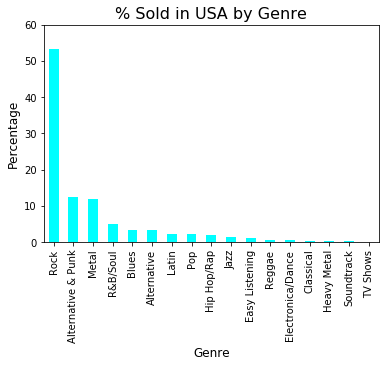

In [9]:
ax = USA_plot_df.plot.bar(x = 'genre_name', 
                     y = 'percentage_sold',
                    legend = False,
                         colormap = 'cool')
ax.set_title('% Sold in USA by Genre', fontsize = 16)
ax.set_xlabel('Genre', fontsize = 12)
ax.set_ylabel('Percentage', fontsize = 12)
ax.set_ylim(0, 60)


<font color=red>CONCLUSION</font>

Rock is by far the dominant track genre sold in the USA, at abt 53% of total track sales.  Alternative & Punk, Metal both comprise abt 12% each.  The remaining genres comprise 5% or less.

Our first 3 albums should be from the Punk, Blues and Pop artists. There is not much difference between Pop and Hip Hop, so if there are difficulties with the Pop album we can choose Hip Hop instead.

<font color=blue>SECOND QUESTION & SOLUTION STRATEGY
<br><br>
*QUESTION*</font>

Is there a difference in the $ amount of sales assigned to each sales support agent?
<br><br>
<font color=blue>STRATEGY</font>

**Query to find the total dollar amount of sales assigned to each sales support agent within the company.** 

- join invoice i to customer c to
- get total i for each support_rep_id c
- get count of COUNT customer_id c for each support_rep_id



In [10]:
sales_per_agent = '''

SELECT
    c.support_rep_id AS sales_agent_id,
    SUM(i.total) AS total_sales,
    e.hire_date AS when_hired,
    COUNT(c.customer_id) AS number_of_customers
FROM
    invoice as i
INNER JOIN
    customer as c ON i.customer_id = c.customer_id
INNER JOIN
    employee as e ON e.employee_id = c.support_rep_id
GROUP BY sales_agent_id
ORDER BY total_sales DESC;
'''



In [11]:
run_query(sales_per_agent)

,sales_agent_id,total_sales,when_hired,number_of_customers
0,3,1731.51,2017-04-01 00:00:00,212
1,4,1584.00,2017-05-03 00:00:00,214
2,5,1393.92,2017-10-17 00:00:00,188


<font color=red>CONCLUSION</font>

No difference between the 3 sales support agents performance in bringing in dollars, considering their time with the company and the number of customers they are assigned to.

<font color=blue>FURTHER INSTRUCTIONS FOR SECOND QUESTION</font>
 
Instructions were to make a plot of total sales.  I think this are unnecessary; the table is sufficient.  But here is a plot per the instructions.

In [12]:
sales_agent = run_query(sales_per_agent)

Text(0, 0.5, '# of Customers')

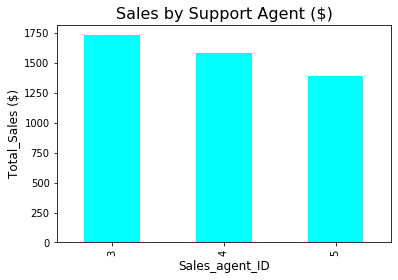

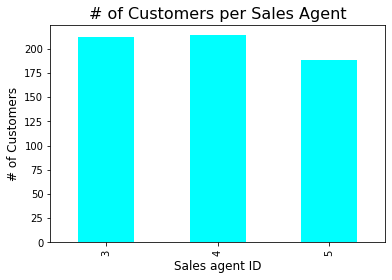

In [13]:
ax_sales = sales_agent.plot.bar(x = 'sales_agent_id', 
                     y = 'total_sales',
                    legend = False,
                         colormap = 'cool')
ax_sales.set_title('Sales by Support Agent ($)', fontsize = 16)
ax_sales.set_xlabel('Sales_agent_ID', fontsize = 12)
ax_sales.set_ylabel('Total_Sales ($)', fontsize = 12)

ax_cust = sales_agent.plot.bar(x = 'sales_agent_id', 
                     y = 'number_of_customers',
                    legend = False,
                         colormap = 'cool')
ax_cust.set_title('# of Customers per Sales Agent', fontsize = 16)
ax_cust.set_xlabel('Sales agent ID', fontsize = 12)
ax_cust.set_ylabel('# of Customers', fontsize = 12)

<font color=blue>THIRD QUESTION INSTRUCTIONS, QUESTION & SOLUTION STRATEGY</font>
<br><br>
<font color=blue>*INSTRUCTIONS*</font>

Analyze sales data for customers from differenct countries, using the country from the customers table.  For countries with only one customer, group these customers as "Other".
<br><br>
<font color=blue>*QUESTION*</font>
<br><br>
- What insights can be obtained by a country to country comparison of:
    - Total number of customers
    - Total sales
    - Average value of sales per customer
    - Average order value

<br>
<font color=blue>*STRATEGY*</font>

*I can already tell this is going to be rough*

**Write a query that collates data on purchases from different countries.** 

- Figure out the grouped values needed to answer the questions
- Get the grouped values by country
- Use CASE, WHEN THEN for the 'one customer' countries as Other
- Calculate by country for 
    - TOTAL no of customers
    - TOTAL value of sales
    - AVG value of sales/customer
    - AVG order value
- Sort by total sales, from highest to lowest, with Other at the bottom

Build each query sequentially and test, assembling into final query using the WITH clause 

In [14]:
test_1 = '''
    SELECT
        c.country AS country,
        COUNT(c.customer_id) AS no_of_customers
    FROM customer as c
    GROUP BY country
    ORDER BY no_of_customers;
    '''
run_query(test_1)

,country,no_of_customers
0,Argentina,1
1,Australia,1
2,Austria,1
3,Belgium,1
4,Chile,1
5,Denmark,1
6,Finland,1
7,Hungary,1
8,Ireland,1
9,Italy,1


In [15]:
test_1a = '''

SELECT
c.country AS country,
COUNT(c.customer_id) AS no_of_customers,
SUM(il.unit_price * il.quantity) AS sales_dollars,
COUNT( DISTINCT c.customer_id) AS no_customers,
COUNT(DISTINCT i.invoice_id) AS no_invoices
FROM customer as c
    
INNER JOIN invoice AS i
ON c.customer_id = i.customer_id
INNER JOIN invoice_line AS il
ON i.invoice_id = il.invoice_id
    
GROUP BY c.country

'''

In [16]:
run_query(test_1a)

,country,no_of_customers,sales_dollars,no_customers,no_invoices
0,Argentina,40,39.60,1,5
1,Australia,82,81.18,1,10
2,Austria,70,69.30,1,9
3,Belgium,61,60.39,1,7
4,Brazil,432,427.68,5,61
5,Canada,541,535.59,8,76
6,Chile,98,97.02,1,13
7,Czech Republic,276,273.24,2,30
8,Denmark,38,37.62,1,10
9,Finland,80,79.20,1,11


In [17]:
#Got help from an associate on the UNION 
test_2 = '''

WITH 
my_view AS
    (
    SELECT
        c.country AS country,
        COUNT( DISTINCT c.customer_id) AS no_of_customers,
        SUM(il.unit_price * il.quantity) AS sales_dollars,
        COUNT(DISTINCT i.invoice_id) AS no_invoices
    FROM customer as c
    
    INNER JOIN invoice AS i
    ON c.customer_id = i.customer_id
    INNER JOIN invoice_line AS il
    ON i.invoice_id = il.invoice_id
    GROUP BY c.country
    ),

country_other AS
    (
    SELECT *
    FROM
        (
        SELECT 
            my_view.*,
            CASE
                WHEN my_view.no_of_customers = 1 
                THEN 1
                ELSE 0
                END
            AS sort
        FROM my_view
        )
    )
    
SELECT *
FROM country_other
WHERE no_of_customers > 1
      UNION
SELECT "Other", SUM(no_of_customers), SUM(sales_dollars), SUM(no_invoices), sort
FROM country_other
WHERE no_of_customers = 1

ORDER BY sort ASC, no_of_customers DESC
    '''

In [18]:
run_query(test_2)

,country,no_of_customers,sales_dollars,no_invoices,sort
0,USA,13,1040.49,131,0
1,Canada,8,535.59,76,0
2,Brazil,5,427.68,61,0
3,France,5,389.07,50,0
4,Germany,4,334.62,41,0
5,United Kingdom,3,245.52,28,0
6,Czech Republic,2,273.24,30,0
7,India,2,183.15,21,0
8,Portugal,2,185.13,29,0
9,Other,15,1094.94,147,1


In [19]:
test_final = '''

WITH 
my_view AS
    (
    SELECT
        c.country AS country,
        COUNT( DISTINCT c.customer_id) AS no_of_customers,
        SUM(il.unit_price * il.quantity) AS sales_dollars,
        COUNT(DISTINCT i.invoice_id) AS no_invoices
    FROM customer as c
    
    INNER JOIN invoice AS i
    ON c.customer_id = i.customer_id
    INNER JOIN invoice_line AS il
    ON i.invoice_id = il.invoice_id
    GROUP BY c.country
    ),

country_other AS
    (
    SELECT *
    FROM
        (
        SELECT 
            my_view.*,
            CASE
                WHEN my_view.no_of_customers = 1 
                THEN 1
                ELSE 0
                END
            AS sort
        FROM my_view
        )
    ),
    

country_other_all AS
    (
    SELECT *
    FROM country_other
    WHERE no_of_customers > 1
          UNION
    SELECT "Other", SUM(no_of_customers), SUM(sales_dollars), SUM(no_invoices), sort
    FROM country_other
    WHERE no_of_customers = 1

    ORDER BY sort ASC, no_of_customers DESC
    )
    
SELECT 
    coa.country, 
    coa.no_of_customers,
    coa.sales_dollars,
ROUND( coa.sales_dollars / coa.no_of_customers, 2)
AS avg_sales_per_customer,
ROUND(coa.sales_dollars / no_invoices, 2)
AS avg_order_value 

FROM country_other_all AS coa  
    '''

In [20]:
run_query(test_final)

,country,no_of_customers,sales_dollars,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,United Kingdom,3,245.52,81.84,8.77
6,Czech Republic,2,273.24,136.62,9.11
7,India,2,183.15,91.58,8.72
8,Portugal,2,185.13,92.57,6.38
9,Other,15,1094.94,73.00,7.45


In [21]:
country_sales_final = '''

WITH 
my_view AS
    (
    SELECT
        c.country AS country,
        COUNT( DISTINCT c.customer_id) AS no_of_customers,
        SUM(il.unit_price * il.quantity) AS sales_dollars,
        COUNT(DISTINCT i.invoice_id) AS no_invoices
    FROM customer as c
    
    INNER JOIN invoice AS i
    ON c.customer_id = i.customer_id
    INNER JOIN invoice_line AS il
    ON i.invoice_id = il.invoice_id
    GROUP BY c.country
    ),

country_other AS
    (
    SELECT *
    FROM
        (
        SELECT 
            my_view.*,
            CASE
                WHEN my_view.no_of_customers = 1 
                THEN 1
                ELSE 0
                END
            AS sort
        FROM my_view
        )
    ),
    

country_other_all AS
    (
    SELECT *
    FROM country_other
    WHERE no_of_customers > 1
          UNION
    SELECT "Other", SUM(no_of_customers), SUM(sales_dollars), SUM(no_invoices), sort
    FROM country_other
    WHERE no_of_customers = 1

    ORDER BY sort ASC, no_of_customers DESC
    )
    
SELECT 
    coa.country, 
    coa.no_of_customers,
    coa.sales_dollars,
ROUND( coa.sales_dollars / coa.no_of_customers, 2)
AS avg_sales_per_customer,
ROUND(coa.sales_dollars / no_invoices, 2)
AS avg_order_value 

FROM country_other_all AS coa;  
    '''
run_query(country_sales_final)

,country,no_of_customers,sales_dollars,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,United Kingdom,3,245.52,81.84,8.77
6,Czech Republic,2,273.24,136.62,9.11
7,India,2,183.15,91.58,8.72
8,Portugal,2,185.13,92.57,6.38
9,Other,15,1094.94,73.00,7.45


In [22]:

country_sales_df = run_query(country_sales_final)

In [23]:
#USA share of total sales minus Other

USA_percent = (country_sales_df.iloc[0]['sales_dollars']/
               (country_sales_df["sales_dollars"].sum() - country_sales_df.iloc[9]['sales_dollars']) 
               *100
              )
print ("US % of sales - 'Other':" + "{:.0f}".format(USA_percent))

US % of sales - 'Other':29


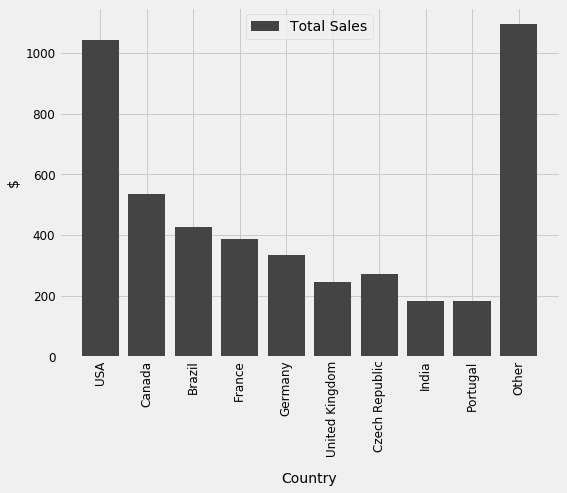

In [24]:
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['legend.loc'] = 'upper center'
plt.style.use('fivethirtyeight')


plt.bar( x = country_sales_df['country'], height = country_sales_df['sales_dollars'], color = '#444444',
       label = "Total Sales")
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks( fontsize = 12)
plt.xlabel("Country", fontsize = 14, labelpad = 15)
plt.ylabel("$", fontsize = 14)
plt.legend(fontsize = 14)

plt.show()

<font color=red>THIRD QUESTION, Part 1- CONCLUSION</font>

There are 15 countries that comprise the Other category, generating only 50 dollars more in sales than the USA.  The USA alone produces 29 \% of the sales (1,040$) compared to the remaining 9 countries.  The next highest country (Canada) produces only 1/2 of the USA revenue.

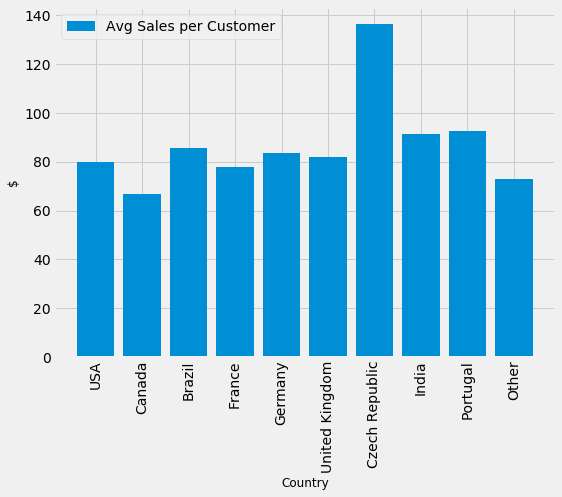

In [25]:
plt.rcParams['figure.figsize'] = [8,6]
plt.style.use('fivethirtyeight')
plt.rcParams['legend.loc'] = 'upper left'

plt.bar(x = country_sales_df['country'], height = country_sales_df['avg_sales_per_customer'], color = '#008fd5', 
        label = "Avg Sales per Customer",)

plt.xticks(rotation = "vertical")
plt.xlabel("Country", fontsize = 12)
plt.ylabel("$", fontsize = 12)
plt.legend(fontsize = 14)

plt.show()

<font color=red>THIRD QUESTION, Part 2- CONCLUSION</font>

It appears that there is a significant difference in average sales/customer in the Czech Republic compared to the rest of the world.  However, there are only 2 customers from the Czech Republic.  All other countries (including "Other") have similar average sales/customer (overall average around 80$), except Canada may be less that the overall average.

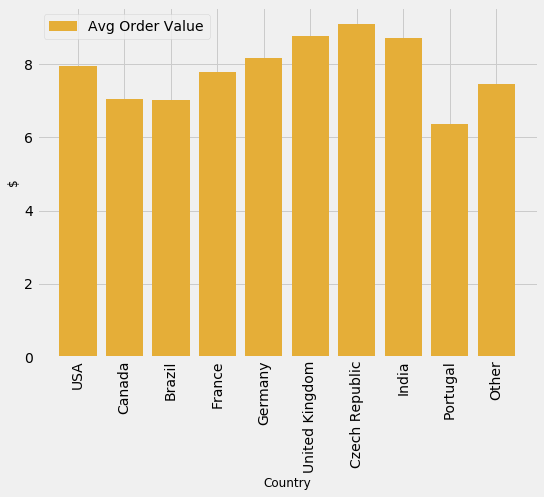

In [26]:
plt.rcParams['figure.figsize'] = [8,6]
plt.style.use('fivethirtyeight')

plt.bar(x = country_sales_df['country'], height = country_sales_df['avg_order_value'], color = '#e5ae38', 
        label = "Avg Order Value")

plt.xticks(rotation = "vertical")
plt.xlabel("Country", fontsize = 12)
plt.ylabel("$", fontsize = 12)
plt.legend()

plt.show()

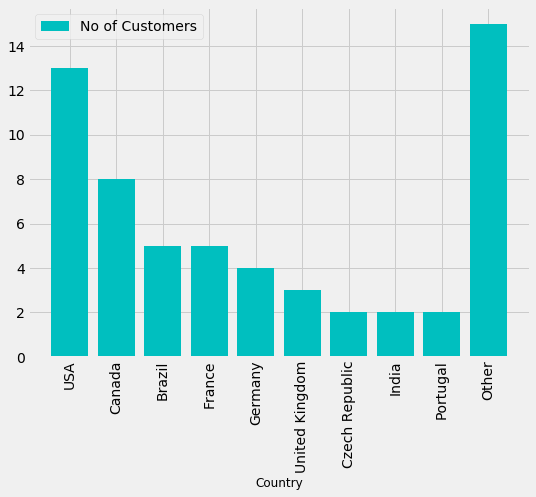

In [27]:
plt.rcParams['figure.figsize'] = [8,6]
plt.style.use('fivethirtyeight')

plt.bar(x = country_sales_df['country'], height = country_sales_df['no_of_customers'], color = 'c', 
        label = "No of Customers")

plt.xticks(rotation = "vertical")
plt.xlabel("Country", fontsize = 12)
plt.legend()
plt.show()

<font color=blue>FOURTH QUESTION INSTRUCTIONS, QUESTION & SOLUTION STRATEGY</font>
<br><br>
<font color=blue>*INSTRUCTIONS*</font>

Write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
- Number of invoices
- Percentage of invoices

In the analysis to answer the question, address the following cases as indicated:

- Albums that have only one or two tracks can be treated as individual tracks
- Manual selection of every track from an album is an album purchase, even if a few individual tracks from other albums were added to their purchase.
<br><br>
<font color=blue>*QUESTION*</font>
<br><br>
What percentage of purchases are individual tracks vs whole albums?
<br><br>
<font color=blue>*STRATEGY*</font>

**Write a query that determines whether purchases were individual tracks or whole albums.** 

- Based on learning from answering the third question, first draw out the data to be obtained and how to get it into the final query table
- It was smart last time to build each query sequentially and test, assembling into final query using the WITH clause.

- Write a query that counts the number of tracks from the `invoice line` table when joined to the `track` table.  When grouped by album_id and invoice_id each row provides the tracks from an album on each invoice.  Because customers can select from multiple albums for a given purchase, there can be more than one row for every invoice.

- Write a query that counts the number of tracks for each album in the `track` table.

- From the first and second queries select only those rows where 1) the track counts are equal between the two queries, and 2) the album_id's are equal, and 3) the track count is > 2 (per the instructions an album purchase which had < 2 is considered a "track" purchase). The number of rows = the number of invoices that were "album" purchases.

- Count the number of invoices from `invoice line` and determine the % of invoices that were album purchases.

In [117]:
# Join album to invoice
invoice_line_table = ''' 
SELECT
    invoice_id,
    COUNT(track_id) AS inv_no_of_tracks,
    track.album_id
FROM invoice_line
JOIN track
    USING (track_id)
GROUP BY invoice_id,track.album_id
ORDER by invoice_id
'''
run_query(invoice_line_table).head()

,invoice_id,inv_no_of_tracks,album_id
0,1,16,91
1,2,1,20
2,2,1,34
3,2,1,39
4,2,1,66


In [47]:
#count tracks/album from track table
count_tracks = ''' 
SELECT 
    COUNT(track_id) AS track_no_of_tracks,
    album_id
FROM track
GROUP BY album_id
'''
run_query(count_tracks).head(5)

,track_no_of_tracks,album_id
0,10,1
1,1,2
2,3,3
3,8,4
4,15,5


In [132]:
#count number of album purchases
track_table = ''' 

WITH invoice_track_ct AS
(
SELECT
    invoice_id,
    COUNT(track_id) AS il_no_of_tracks,
    track.album_id AS track_album_id
FROM invoice_line
JOIN track
    USING (track_id)
GROUP BY invoice_id,track.album_id
),

track_track_ct AS
(
SELECT 
    COUNT(track_id) AS track_no_of_tracks,
    album_id
FROM track
GROUP BY album_id
)

SELECT 
    invoice_track_ct.invoice_id,
    invoice_track_ct.il_no_of_tracks,
    track_track_ct.track_no_of_tracks
FROM
    invoice_track_ct,
    track_track_ct
WHERE
    invoice_track_ct.il_no_of_tracks = track_track_ct.track_no_of_tracks
        AND
    invoice_track_ct.track_album_id = track_track_ct.album_id
        AND
    invoice_track_ct.il_no_of_tracks > 2
GROUP BY
    invoice_track_ct.invoice_id
'''

In [138]:
run_query(track_table).head()

,invoice_id,il_no_of_tracks,track_no_of_tracks
0,1,16,16
1,5,17,17
2,23,10,10
3,24,12,12
4,31,20,20


In [127]:
df_invoice_albums = run_query(track_table)
print("total no. of album invoices: ", df_invoice_albums["invoice_id"].count())

total no. of album invoices:  111


In [143]:
count_invoices = '''
SELECT
    COUNT(invoice_id)
FROM
    invoice_line
'''

run_query(count_invoices)
df_count_invoices = run_query(count_invoices)

print("total no. of album invoices: ", df_invoice_albums["invoice_id"].count())
print("total no of invoices:" , df_count_invoices.iloc[0,0])
print("\n")
album_pct = df_invoice_albums["invoice_id"].count() / df_count_invoices.iloc[0,0] *100
print("% of invoices for albums:" + "{:.0f}".format(album_pct) + "%")


total no. of album invoices:  111
total no of invoices: 4757


% of invoices for albums:2%


FOURTH QUESTION - CONCLUSION

Customers rarely purchase whole albums, instead picking the tracks they want.  